In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [4]:
# 1. Load and Visualize the Data
data = pd.read_excel("Gold_price_gbp.xlsx",index_col="Date", parse_dates=True)
#prices = data['GBP'].values

# Convert 'Date' column to datetime
#data['Date'] = pd.to_datetime(data['Date'])

In [6]:
# Set 'Date' column as index
#data.set_index('Date', inplace=True)

# Sort the data based on the index
#data.sort_index(inplace=True)

In [7]:
# Splitting the data into train and test sets
train_size = int(len(data) * 0.8)
train_data, test_data = data.iloc[:train_size], data.iloc[train_size:]


In [8]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [9]:
# Function to prepare data for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Set time steps for LSTM
time_steps = 10

In [10]:
# Prepare the train and test data
X_train, y_train = prepare_data(train_scaled, time_steps)
X_test, y_test = prepare_data(test_scaled, time_steps)

# Reshape input data to be 3-dimensional for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [11]:
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/100
296/296 [==============================] - 11s 15ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 2/100
296/296 [==============================] - 3s 10ms/step - loss: 1.0651e-04 - val_loss: 0.0029
Epoch 3/100
296/296 [==============================] - 3s 11ms/step - loss: 1.0246e-04 - val_loss: 0.0020
Epoch 4/100
296/296 [==============================] - 3s 11ms/step - loss: 1.0756e-04 - val_loss: 0.0023
Epoch 5/100
296/296 [==============================] - 3s 11ms/step - loss: 9.9668e-05 - val_loss: 0.0041
Epoch 6/100
296/296 [==============================] - 3s 10ms/step - loss: 1.3377e-04 - val_loss: 0.0017
Epoch 7/100
296/296 [==============================] - 3s 11ms/step - loss: 9.1132e-05 - val_loss: 0.0013
Epoch 8/100
296/296 [==============================] - 3s 10ms/step - loss: 9.9496e-05 - val_loss: 6.9741e-04
Epoch 9/100
296/296 [==============================] - 3s 11ms/step - loss: 9.0511e-05 - val_loss: 6.7528e-04
Epoch 10/100
296/296 [===================

In [27]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

74/74 [==============================] - 0s 4ms/step


In [29]:
import math
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

def mean_absolute_scaled_error(y_true, y_pred):
    naive_forecast = np.roll(y_true, 1)
    naive_forecast[0] = y_true[0]
    return mean_absolute_error(y_true, y_pred) / mean_absolute_error(y_true, naive_forecast)

mae = mean_absolute_error(y_test[0], test_predict[:,0])
mse = mean_squared_error(y_test[0], test_predict[:,0])
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test[0], test_predict[:,0])
smape = symmetric_mean_absolute_percentage_error(y_test[0], test_predict[:,0])
mase = mean_absolute_scaled_error(y_test[0], test_predict[:,0])
r2 = r2_score(y_test[0], test_predict[:,0])

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'sMAPE: {smape}')
print(f'MASE: {mase}')
print(f'R2: {r2}')

MAE: 10.198321341496758
MSE: 182.70291388724695
RMSE: 13.516764179612181
MAPE: 0.887568309789254
sMAPE: 0.8840486532467248
MASE: 1.311608882873837
R2: 0.9976538203935288


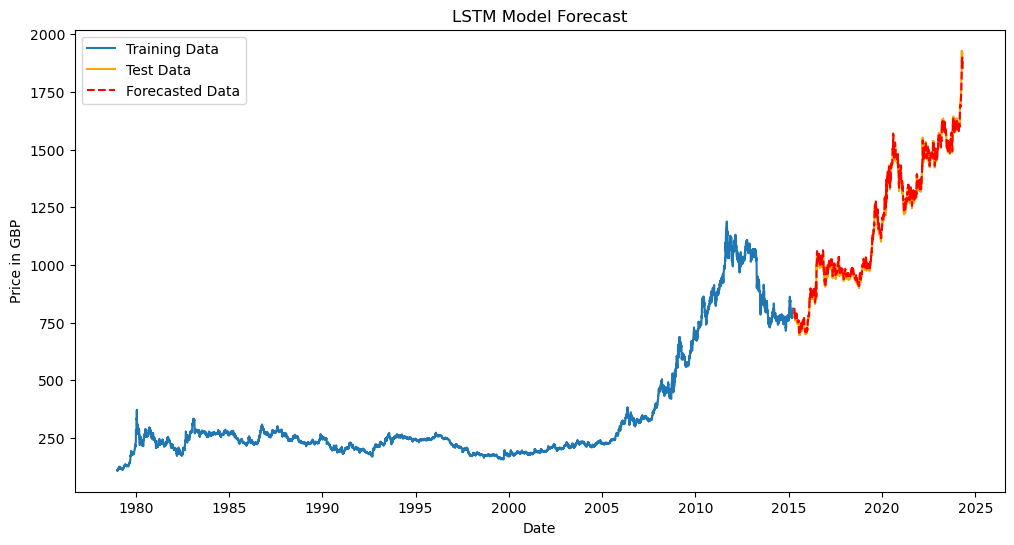

In [30]:
# Plot training, test, and predicted data
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(data.index[:train_size], data['GBP'][:train_size], label='Training Data')

# Plot test data
plt.plot(data.index[train_size+time_steps:], data['GBP'][train_size+time_steps:], label='Test Data', color='orange')

# Plot training predictions
#plt.plot(data.index[time_steps:train_size], train_predictions, label='Training Predictions', linestyle='--', color='blue')

# Plot test predictions
plt.plot(data.index[train_size+time_steps:], test_predictions, label='Forecasted Data', linestyle='--', color='red')

plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Price in GBP')
plt.legend()
plt.show()